In [0]:
from google.colab import files
files.upload()


In [2]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip -q train.zip
!unzip -q test.zip
!rm train.zip test.zip

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 43.9MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 84.9MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 60.5MB/s]
 99% 162M/163M [00:11<00:00, 12.1MB/s]
100% 163M/163M [00:11<00:00, 14.7MB/s]
 66% 25.0M/37.9M [00:00<00:00, 63.4MB/s]
100% 37.9M/37.9M [00:00<00:00, 150MB/s] 


### TGT Salt Classification Challenge


In [0]:
import numpy as np
import gc
import cv2
def rle_to_output(x):
  if type(x)!=np.float:
    x = list(map(int, x.split(' ')))
    out = np.zeros(101*101,dtype=np.int64)
    for i in range(0,len(x),2):
      out[ x[i]-1:x[i+1]+x[i]-1 ] = 1
    return np.reshape(np.array(out),(101,101)).T
  else:
    return np.zeros((128,128),dtype=np.int64)

In [2]:
import glob
import pandas as pd

data = pd.read_csv('train.csv')
depths = pd.read_csv('depths.csv')
data = pd.merge(data,depths,on='id',how='left')
X = data.id.apply(lambda x: "images/"+str(x)+'.png')
Y = data.id.apply(lambda x: "masks/"+str(x)+'.png')
Z = data.z
data.head(5)

,id,rle_mask,z
0,575d24d81d,NaN,843
1,a266a2a9df,5051 5151,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


### Basic Visualization

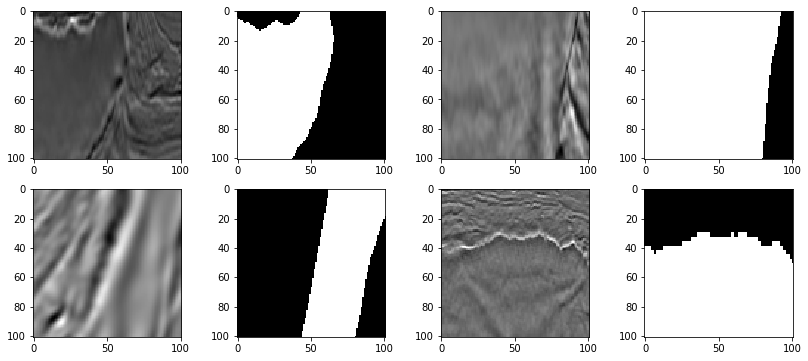

In [3]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[15,511,1130,3452]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  ax[l[0]][l[1]].imshow( cv2.imread(X[index]) )
  ax[l[0]][l[1]+1].imshow( cv2.imread(Y[index]) )

In [0]:
from skimage.transform import resize

img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True,)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [5]:
all_images = glob.glob('masks/*')
print(len(all_images), X.shape)

IMG_DIM = (128,128,3)

from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, array_to_img
X = np.array([ upsample(img_to_array( load_img(file)) ) for file in X.values ])
Y = np.array([ upsample(img_to_array( load_img(file, color_mode='grayscale' ))) for file in Y.values ])/255


X = np.append( X, [ np.fliplr(x) for x in X], axis=0 )
Y = np.append( Y, [ np.fliplr(y) for y in Y], axis=0 )
Z = pd.concat([Z,Z],axis=0)

print(X.shape,Y.shape,Z.shape)

4000 (4000,)


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(8000, 128, 128, 3) (8000, 128, 128, 1) (8000,)


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

### Implementing a Fully Convolutional Network called UNET for Image Segmentation

In [0]:
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def lovasz_grad(gt_sorted):
  """
  Computes gradient of the Lovasz extension w.r.t sorted errors
  See Alg. 1 in paper
  """
  gts = tf.reduce_sum(gt_sorted)
  intersection = gts - tf.cumsum(gt_sorted)
  union = gts + tf.cumsum(1. - gt_sorted)
  jaccard = 1. - intersection / union
  jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
  return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss
  
def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_hinge_flat(logits, labels):
    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss
  
def weighted_loss(logit,labels):
  return 0.7*lovasz_hinge(logit,labels)+0.3*bce_dice_loss(logit,labels)

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from keras import optimizers
from keras.applications import VGG19
from keras.models import Model
IMG_DIM = (128,128,3)

vgg = VGG19(weights='imagenet',include_top=False, input_shape=IMG_DIM)
vgg.layers.pop()
vgg.trainable=False
for layer in vgg.layers[:-4]:
    layer.trainable = False
    
def conv2d_block( input_tensor, n_filters, kernel_size = (3,3)):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(x)
  return x

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(vgg.get_layer('block5_conv4').output)
u1 = concatenate([u1,vgg.get_layer('block4_conv4').output])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512)

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,vgg.get_layer('block3_conv4').output])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256)

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,vgg.get_layer('block2_conv2').output])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128)

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,vgg.get_layer('block1_conv2').output])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4, 64)

output = Conv2D(1, (1, 1), activation='sigmoid')(c4)
unet = Model(vgg.input, output)

"""
from uresnet import UResNet34
unet = UResNet34(input_shape=(128,128,3), resnet_untrainable = 30 )
---------------------------------------------
#!git clone https://github.com/qubvel/segmentation_models
#!pip install -q -r segmentation_models/requirements.txt
from segmentation_models import Unet
unet = Unet(backbone_name="vgg19",input_shape=(128,128,3))
for layer in unet.layers[:17]:
  layer.trainable = False
---------------------------------------------
"""

def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0      
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
    return np.mean(metric)

def iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

unet.compile(optimizer=optimizers.Adam(lr=1e-3), loss=weighted_loss, metrics=['accuracy',iou_metric])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
from sklearn.model_selection import train_test_split

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, 
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
reduceLR = ReduceLROnPlateau(patience=5, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

X, X_val, Y, Y_val = train_test_split(X,Y,test_size=0.2,stratify=LabelEncoder().fit_transform(pd.qcut(Z,10)))

train_generator = train_datagen.flow(X, Y, batch_size=32)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=32)
history = unet.fit_generator(train_generator, steps_per_epoch=40, epochs=200,
                              validation_data=val_generator, validation_steps=20, 
                              verbose=2,callbacks=callback_list)

unet = load_model('model_best_checkpoint.h5', custom_objects={'weighted_loss': weighted_loss,'iou_metric':iou_metric}) #or compile = False

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 32s - loss: 1.2166 - acc: 0.7287 - iou_metric: 0.1430 - val_loss: 0.8694 - val_acc: 0.7986 - val_iou_metric: 0.2153

Epoch 00001: val_loss improved from inf to 0.86935, saving model to model_best_checkpoint.h5
Epoch 2/200
 - 21s - loss: 0.9518 - acc: 0.8490 - iou_metric: 0.4016 - val_loss: 0.8808 - val_acc: 0.8812 - val_iou_metric: 0.4627

Epoch 00002: val_loss did not improve from 0.86935
Epoch 3/200
 - 21s - loss: 0.8791 - acc: 0.8810 - iou_metric: 0.4891 - val_loss: 0.9406 - val_acc: 0.8916 - val_iou_metric: 0.5542

Epoch 00003: val_loss did not improve from 0.86935
Epoch 4/200
 - 21s - loss: 0.8474 - acc: 0.8906 - iou_metric: 0.5364 - val_loss: 0.7889 - val_acc: 0.8857 - val_iou_metric: 0.4677

Epoch 00004: val_loss improved from 0.86935 to 0.78892, saving model to model_best_checkpoint.h5
Epoch 5/200
 - 21s - loss: 0.8170 - acc: 0.8995 - iou_metric: 0.5644 - val_loss: 0.7677 - val_acc: 0.8842 - val_iou_metric: 0.5155



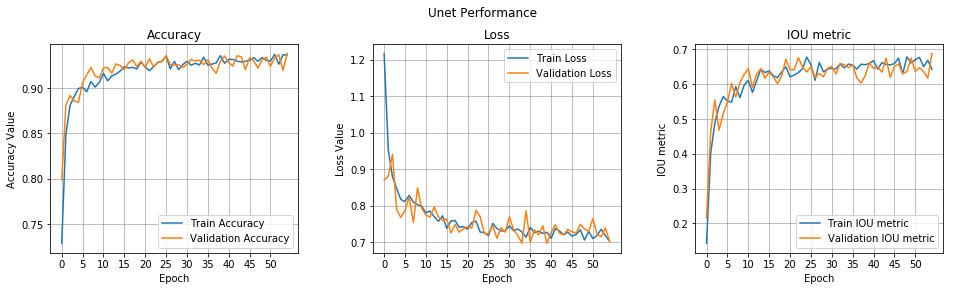

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['iou_metric'], label='Train IOU metric')
ax3.plot(epoch_list, history.history['val_iou_metric'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

## To Submit

In [0]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0      
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        s = []
        for thresh in np.arange(0.5, 1, 0.05):
            s.append(iou > thresh)
        metric.append(np.mean(s))
    return np.mean(metric)

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)
  
def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(3, 8, 30)
  ious = np.array([iou_metric_batch(mask_org, np.int32(predicted > threshold)) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best


3968

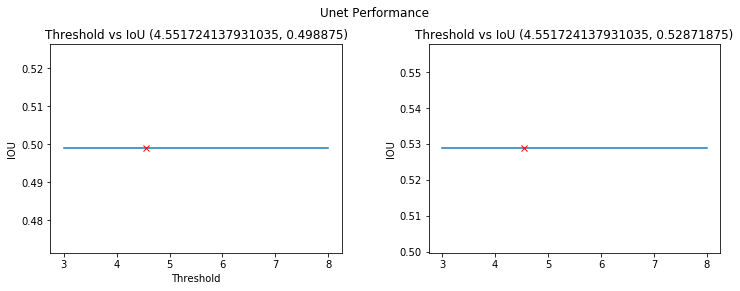

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_val,unet.predict(X_val))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))
del X,Y,X_val,Y_val; gc.collect()

In [16]:
submission = pd.read_csv('sample_submission.csv',usecols=['id'])
submission.head()

,id
0,155410d6fa
1,78b32781d1
2,63db2a476a
3,17bfcdb967
4,7ea0fd3c88


In [17]:
outputs = np.empty((0, 128, 128, 1))
for i,j in [(0,6000),(6000,12000),(12000,18000)]:
  output = [ 'images/{}.png'.format(i) for i in submission.id[i:j].values ]
  output = np.array([ upsample(img_to_array( load_img(file) )) for file in output ])
  output = np.array(output)/255
  outputs = np.append( outputs, unet.predict(output), axis=0)  
  del output; gc.collect()
  print(i,j)
outputs.shape

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0 6000
6000 12000
12000 18000


(18000, 128, 128, 1)

In [0]:
THRESHOLD = 0.50
def process_output(out):
  im = cv2.resize(out, (101,101), interpolation = cv2.INTER_AREA)
  return (np.squeeze(im)>THRESHOLD)*1

def rle_encode(im):
  im = im.T
  im = np.reshape(im,(101*101))
  pixels = im.flatten(order = 'F')
  pixels = np.concatenate([[0], pixels, [0]])
  runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
  runs[1::2] -= runs[::2]
  return ' '.join(str(x) for x in runs)

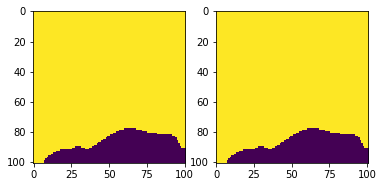

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
im = cv2.resize(outputs[0], (101,101), interpolation = cv2.INTER_AREA)
im = (np.squeeze(im)>THRESHOLD)*1
ax1.imshow(im)
im = rle_encode(im)
im = rle_to_output(im)
ax2.imshow(im)

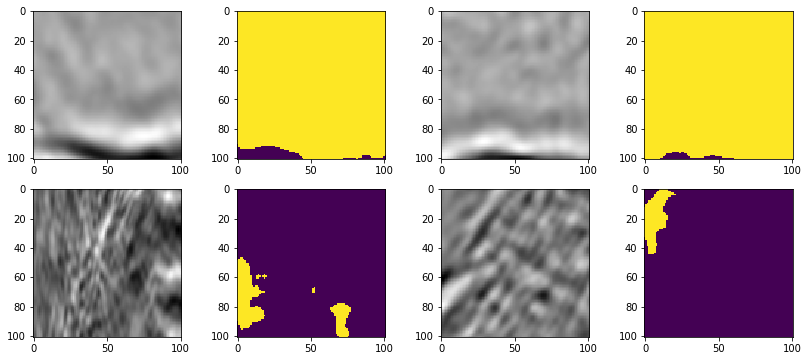

In [20]:
fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(14,6))
indexs=[145,678,1456,13453]
for index,l in zip(indexs,[(0,0),(0,2),(1,0),(1,2)]):
  im = cv2.imread("images/{}.png".format(submission.iloc[index].id))
  ax[l[0]][l[1]].imshow(im)
  ax[l[0]][l[1]+1].imshow(process_output(outputs[index]))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Text(0.5, 1.0, 'Predicted')

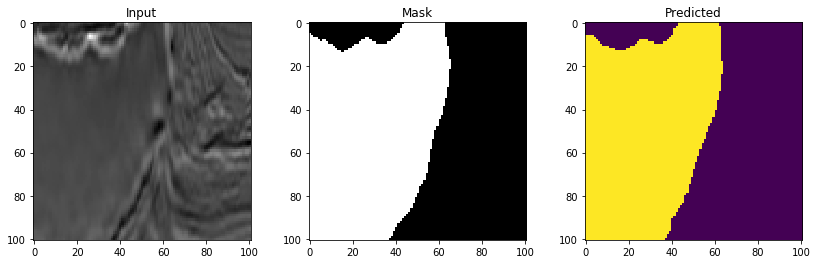

In [21]:
index=15
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(14,4))
img = np.array([ upsample(img_to_array(load_img('images/'+data.iloc[index].id+'.png' ) ) )])/255
temp = unet.predict(img)
ax[0].imshow(cv2.imread('images/'+data.iloc[index].id+'.png'));ax[0].set_title('Input')
ax[1].imshow(cv2.imread('masks/'+data.iloc[index].id+'.png'));ax[1].set_title('Mask')
ax[2].imshow(process_output(temp[0]),label="Predicted");ax[2].set_title('Predicted')

In [22]:
submission['rle_mask'] = [ rle_encode(process_output(o)) for o in outputs ]
submission.head()

,id,rle_mask
0,155410d6fa,1 806 809 98 910 97 1011 96 1112 96 1213 95 13...
1,78b32781d1,58 44 159 44 259 45 358 47 457 49 557 50 657 5...
2,63db2a476a,8228 1 8230 1 8327 9 8416 25 8508 36 8601 45 8...
3,17bfcdb967,4550 1 4555 1 4561 16 4618 7 4636 64 4712 5490
4,7ea0fd3c88,655 1 696 2 796 4 857 1 889 2 892 9 996 6 1100 2


In [0]:
submission.to_csv('submission.csv',index=False)

In [24]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "uvgg19net iou_metric bce_dice+lovartz "

100% 5.44M/5.44M [00:01<00:00, 3.05MB/s]
Successfully submitted to TGS Salt Identification Challenge